# Investigación de la Demografía de los Clientes de Blackwell Electronics
                                                                                Autor: Rodrigo Guerrero Zerbini

## Introducción

Para dar seguimiento al proceso de investigación de las compras en Blackwell Electronics, Danielle Sherman ahora ha solicitado una respuesta a las siguientes preguntas:

1. Existen diferencias de edad de los clientes entre regiones? Podemos predecir la edad de un cliente en una región según otros dados demográficos?
2. Existe una correlación entre la edad de un cliente y el tipo de compra (por internet o en tienda física)? Se puede predecir el tipo de compra usando otras variables? (Martin Goodrich, vicepresidente de ventas, supone que clientes que compran en tiendas físicas son mayores que aquellos que compran por internet. Será necesário verificar si es verdadera su hipótesis.)

## Objetivo

Utilizar herramientas de análisis de datos en Python y modelos de *machine learning* para responder a las preguntas anteriormente mencionadas y realizar predicciones.

## Importación de librerías en Python

Primeramente, se importan las librerías necesarias para la investigación.

In [1]:
# importación de librerías y funciones en Python
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

La siguiente célula permite la visualización de los gráficos de matplotlib, justo debajo del código python para generarlos.

In [2]:
%matplotlib inline

## Lectura de los datos

Se hace la lectura del archivo csv en un dataframe llamado data y se visualiza las primeras 5 líneas.

In [3]:
# importación de datos
data = pd.read_csv('Demographic_Data.csv')
data.head()

,in-store,age,items,amount,region
0,0,37,4,281.03,2
1,0,35,2,219.51,2
2,1,45,3,1525.70,4
3,1,46,3,715.25,3
4,1,33,4,1937.50,1


A continuación, se observa los tipos de las variables del dataframe. Todas son del tipo int64, a excepción de **amount**, que es del tipo float64. 

Son todos tipos numéricos, justamente lo que se requiere para los modelos de machine learning que serán usados más adelante. Por eso, no será necesário hacer ninguna conversión de tipos.

Además, no hay valores ausentes. Cada una de las 5 columnas presentan 80000 valores no nulos.

In [4]:
# tipos de variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   in-store  80000 non-null  int64  
 1   age       80000 non-null  int64  
 2   items     80000 non-null  int64  
 3   amount    80000 non-null  float64
 4   region    80000 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.1 MB


## Existen diferencias de edad de los clientes entre regiones?

Según el diagrama de violín siguiente, las edades de la región 2 (sur) son ligeramente más altas que las demás. Esta región presenta tanto la mediana como las edades mínima y máxima más elevadas que los valores correspondientes de las demás.

No obstante, las cuatro regiones comparten una larga franja de edad (entre 28 y 63 años). Por esta razón, se supone que sea difícil prever la edad de un cliente considerando solo su región.

Edad mínima de la región 2:  28
Edad máxima de la región 4:  63


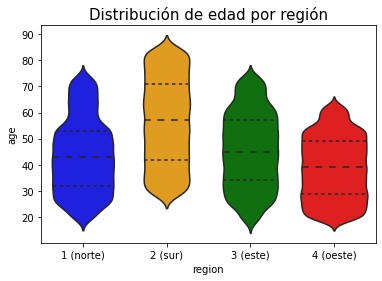

In [5]:
ax = sns.violinplot(x="region", y="age", inner='quartile', data=data, 
                    palette={1:'blue', 2:'orange', 3:'green', 4:'red'})
ax.set_title('Distribución de edad por región', fontsize=15)
ax.set_xticklabels(('1 (norte)', '2 (sur)', '3 (este)', '4 (oeste)'))

print('Edad mínima de la región 2: ', data[data['region'] == 2]['age'].min())
print('Edad máxima de la región 4: ', data[data['region'] == 4]['age'].max())

A continuación, se visualiza la matriz de correlación entre las variables del dataframe. Se observa que la mayor correlación en valores absolutos se encuentra entre **region** y **amount**. Por otro lado, la variable **items** no presenta correlación con las otras variables.

<AxesSubplot:>

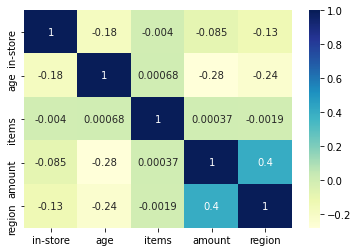

In [6]:
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap="YlGnBu")

En la tabla a seguir, se interpreta la intensidad de las correlaciones de la matriz.

Inexistente|Débil|Moderada
:-----|:-----|:----- 
items / in-store|region / in-store|region / amount
items / age|region / age|
items / amount|amount / age|
items / region|in-store / age|
amount / in-store| |

Por las bajos valores que presenta la variable **items**, no se la llevará en consideración para la siguiente visualización. 

De acuerdo con los gráficos a seguir: 

- Los clientes mayores de la región 2 (sur) compran más por internet.
- Los clientes con edades más elevadas que compran en tienda física son mayoritariamente de la región 3 (este).
- Las transacciones con valores más altos son realizadas por internet.
- El valor de las transacciones disminuye a medida que la edad crece.

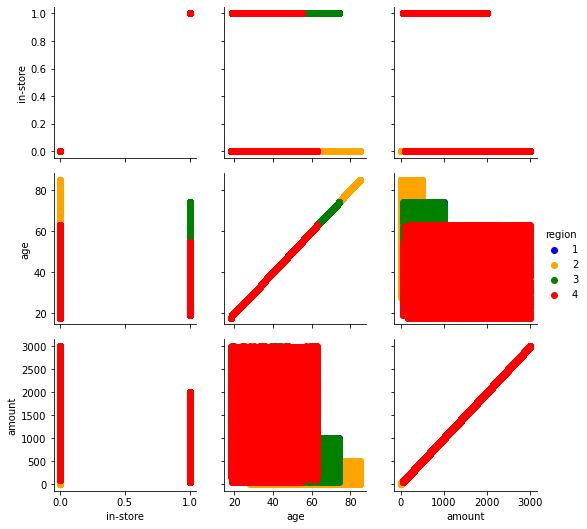

In [7]:
g = sns.PairGrid(data, vars=['in-store', 'age', 'amount'],
                 hue='region', palette={1:'blue', 2:'orange', 3:'green', 4:'red'})
g.map(plt.scatter)
g.add_legend()

# replace labels
#new_labels = ['norte', 'sur', 'este', 'oeste']
#for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# legend_data={1:'norte', 2:'sur', 3:'este', 4:'oeste'}

## Discretización de Edad

La columna **age** tiene 68 valores distintos que varian de 18 a 85 años. Su distribución puede ser observada abajo.

In [8]:
print('Cantidad de edades distintas: ', len(data['age'].unique()))
print('Edad mínima: ', data['age'].min())
print('Edad máxima: ', data['age'].max())

Cantidad de edades distintas:  68
Edad mínima:  18
Edad máxima:  85


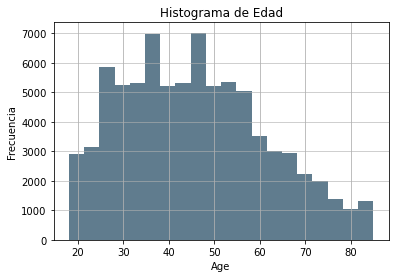

In [9]:
data['age'].plot.hist(grid=True, bins=20, color='#607c8e')
plt.title('Histograma de Edad')
plt.xlabel('Age')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)

A continuación, la variable edad es discretizada y distribuída en tres *bins* de misma anchura (aproximadamente 22 años):

- 18 <= age <= 40 --> bin = 0.0
- 41 <= age <= 63 --> bin = 1.0
- 63 <= age <= 85 --> bin = 2.0

Una nueva variable **age-bin** es adjuntada al dataframe.

Esta técnica es utilizada para facilitar el proceso de predecir la edad usando sus respectivos *bins*, ya que hacerlo con la variable contínua **age** sería impracticable.

In [10]:
# uso de sklearn para discretización de edad
n_bins = 3 # número de bins
est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy = "uniform")

data['age-bin'] = est.fit_transform(data[['age']])
data.head(10)

,in-store,age,items,amount,region,age-bin
0,0,37,4,281.0300,2,0.0
1,0,35,2,219.5100,2,0.0
2,1,45,3,1525.7000,4,1.0
3,1,46,3,715.2500,3,1.0
4,1,33,4,1937.5000,1,0.0
5,0,24,3,1314.2000,4,0.0
6,0,43,6,8.5472,2,1.0
7,1,66,5,819.9800,3,2.0
8,1,51,5,908.3100,1,1.0
9,1,47,3,767.5400,1,1.0


## Evaluación de modelos

Para comenzar, se separan las columnas de características (**X**) de la variable dependiente (**y**) que se quiere predecir. En este caso, **y** será la variable **age-bin** y todas las demás serán las características en el modelo de *machine learning*.

In [11]:
# features
X = data[['in-store', 'items', 'amount', 'region']]

# target
y = data['age-bin']

A continuación, 80% de los datos son separados para entrenar el modelo y los 20% restantes para probar su eficacia. 

Se verifica que la distribución de edades en los conjuntos de entrenamiento y validación son bastante similares. Es decir, los datos han sido divididos de manera equitativa.

In [12]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

In [13]:
# resultados del split
print('Conjunto de entrenamiento tiene {} amuestras.'.format(X_train.shape[0]))
print('Conjunto de validación tiene {} amuestras.'.format(X_test.shape[0]))
print('')

print('Distribución de edades en el conjunto de entrenamiento:')
print(y_train.value_counts(normalize=True).sort_index())
print('')

print('Distribución de edades en el conjunto de validación:')
print(y_test.value_counts(normalize=True).sort_index())
print('')

Conjunto de entrenamiento tiene 64000 amuestras.
Conjunto de validación tiene 16000 amuestras.

Distribución de edades en el conjunto de entrenamiento:
0.0    0.412391
1.0    0.429406
2.0    0.158203
Name: age-bin, dtype: float64

Distribución de edades en el conjunto de validación:
0.0    0.406500
1.0    0.432875
2.0    0.160625
Name: age-bin, dtype: float64



Se empleará la validación cruzada de 10 carpetas para estimar la exactidud (*accuracy*) de los tres modelos de clasificación a seguir:

- *Decision Tree*
- *Random Forest*
- *Gradient Boosting*

In [14]:
models = [('Decision Tree', DecisionTreeClassifier()), 
          ('Random Forest', RandomForestClassifier()), 
          ('Gradient Boosting', GradientBoostingClassifier())]

results = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results.mean())
    print('%s: accuracy = %f' % (name, cv_results.mean()))
    
    curr_model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Matriz de confusión')
    print(confusion_matrix(y_test, y_pred), end='\n\n')

Decision Tree: accuracy = 0.427625
Matriz de confusión
[[3011 2795  698]
 [2861 3031 1034]
 [ 704 1066  800]]

Random Forest: accuracy = 0.429156
Matriz de confusión
[[3045 2756  703]
 [2876 2988 1062]
 [ 658 1064  848]]

Gradient Boosting: accuracy = 0.473875
Matriz de confusión
[[3657 2273  574]
 [3008 2968  950]
 [  70 1504  996]]



De acuerdo con los *accuracies* y las matrices de confusión obtenidas, Gradient Boosting es el modelo que presenta la mejor exactidud: un 47.3% para una profundidad máxima de 3 (valor por defecto de la función). A continuación, se probarán para este modelo profundidades máximas entre 4 y 10 para verificar si hay una mejora del *accuracy*.

In [15]:
best_score = max(results)
best_score

0.47387500000000005

In [16]:
for i in range(4,10):
    print('depth = ', i)
    model = GradientBoostingClassifier(max_depth=i)
    kfold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_depth = i
        print("Nuevo mejor score encontrado = {} para depth = {}".format(best_score, best_depth))

print('')
print('Resultado final:')
print("Mejor score = {} para depth = {}".format(best_score, best_depth))

depth =  4
Nuevo mejor score encontrado = 0.475171875 para depth = 4
depth =  5
depth =  6
depth =  7
depth =  8
depth =  9

Resultado final:
Mejor score = 0.475171875 para depth = 4


## Entrenamiento del modelo y predicciones

Una ligera mejora ha sido encontrada, por lo que la profundidad 4 será usada para la construcción del modelo. 

Luego, se realizan las predicciones usando el conjunto de validación y se imprime el relatório de clasificación. El modelo final presenta una exactitud de 48% y valores de *precision* y *recall* que no superan los 55%. 

Finalmente, el modelo de clasificación no logra cumplir su objetivo de predecir la franja de edad a partir de las otras variables. Una posible explicación es la correlación débil o inexistente entre **age** y las demás variables. En otras palabras, el clasificador no consigue aprender de los datos y no es capaz de realizar buenas predicciones.

In [17]:
# predictions
gbc = GradientBoostingClassifier(max_depth=best_depth)
model = gbc.fit(X_train,y_train)

preds = model.predict(X_test)

In [18]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.54      0.55      0.55      6504
         1.0       0.44      0.45      0.45      6926
         2.0       0.40      0.34      0.37      2570

    accuracy                           0.48     16000
   macro avg       0.46      0.45      0.45     16000
weighted avg       0.47      0.48      0.47     16000



## Existe una correlación entre la edad de los clientes y el tipo de compra?

De acuerdo con la tabla de correlaciones calculada al principio, la correlación entre **age** y **in-store** es de apenas -0.18. A continuación, se puede observar un gráfico de las edades en relación al tipo de compra (en tienda físca u online).

Es posible observar que la correlación es efectivamente ínfima, ya que una larga franja de edad esta asociada tanto a compras en tiendas físicas como online. A pesar de ello, todos los clientes con una edad superior a 74 han comprado por internet. La edad media de los clientes que compran por internet (49) también es más alta que la media de los que compran en tienda física (43).

<AxesSubplot:xlabel='in-store', ylabel='age'>

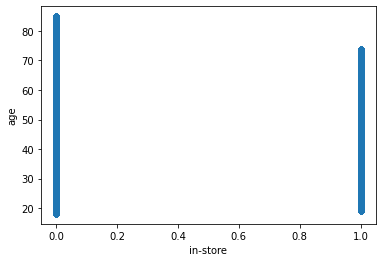

In [19]:
data.plot(x='in-store', y='age', kind='scatter')

In [20]:
max_age_instore = data[data['in-store'] == 1]['age'].max()
print('Máxima edad observada en tienda física: {}'.format(max_age_instore))

Máxima edad observada en tienda física: 74


In [21]:
### Cálculo de la edad media por tipo de compra
online = data[data['in-store'] == 0]
fisica = data[data['in-store'] == 1]

print('Edad media para compras online: {}'.format(online['age'].mean()))
print('Edad media para compras en tienda fisica: {}'.format(fisica['age'].mean()))

Edad media para compras online: 48.559325
Edad media para compras en tienda fisica: 42.956525


### Relación del tipo de compra con otras variables

En los gráficos a seguir, es posible observar que:

- Todas los clientes que han gastado más de $ 1999.90 han comprado por internet.
- Todos los clientes de la región 1 (norte) compran apenas en tienda física.
- Todos los clientes de la región 2 (sur) compran apenas por internet.
- No hay relación entre el número de artículos y el tipo de compra.

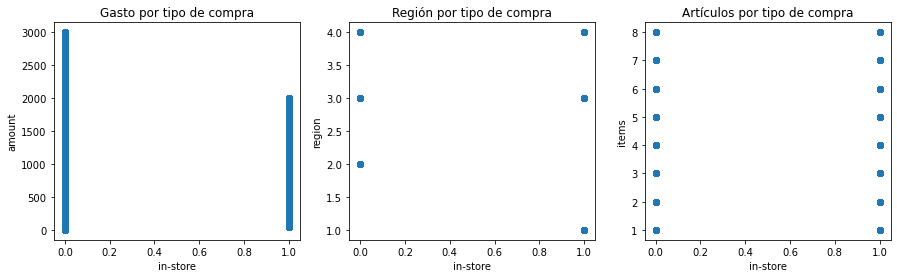

Máximo gasto observado en tienda física: 1999.90


In [22]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(data['in-store'], data['amount'])
ax1.set_title('Gasto por tipo de compra')
ax1.set_xlabel('in-store')
ax1.set_ylabel('amount')
# editar tick params  ax1.tick_params(...)

ax2.scatter(data['in-store'], data['region'])
ax2.set_title('Región por tipo de compra')
ax2.set_xlabel('in-store')
ax2.set_ylabel('region')
# editar tick params  ax1.tick_params(...)

ax3.scatter(data['in-store'], data['items'])
ax3.set_title('Artículos por tipo de compra')
ax3.set_xlabel('in-store')
ax3.set_ylabel('items')
# editar tick params  ax1.tick_params(...)

plt.show()

max_amount_instore = data[data['in-store'] == 1]['amount'].max()
print('Máximo gasto observado en tienda física: {:.2f}'.format(max_amount_instore))

## Evaluación de modelos

Una vez más, se separan las columnas de características (**X**) de la variable dependiente (**y**) que se quiere predecir. En este caso, **y** será la variable **in-store** y se tomarán **age**, **amount** y **region** como características (**items** no entra en el modelo por la inexistencia de correlación).

A continuación, los datos se dividen para entrenamiento y validación y se verifica que la distribución de tipo de compra en los conjuntos de entrenamiento y validación son similares.

In [23]:
# features
X = data[['age', 'amount', 'region']]

# target
y = data['in-store']

In [24]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

In [25]:
# resultados del split
print('Conjunto de entrenamiento tiene {} amuestras.'.format(X_train.shape[0]))
print('Conjunto de validación tiene {} amuestras.'.format(X_test.shape[0]))
print('')

print('Distribución de tipo de compra en el conjunto de entrenamiento:')
print(y_train.value_counts(normalize=True).sort_index())
print('')

print('Distribución de tipo de compra en el conjunto de validación:')
print(y_test.value_counts(normalize=True).sort_index())
print('')

Conjunto de entrenamiento tiene 64000 amuestras.
Conjunto de validación tiene 16000 amuestras.

Distribución de tipo de compra en el conjunto de entrenamiento:
0    0.499984
1    0.500016
Name: in-store, dtype: float64

Distribución de tipo de compra en el conjunto de validación:
0    0.500062
1    0.499937
Name: in-store, dtype: float64



Se empleará la validación cruzada de 10 carpetas para estimar la exactidud (*accuracy*) del modelo de árbol de decisión.

In [26]:
model = DecisionTreeClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
print('%s: accuracy = %f' % (name, results.mean()))
    
tree = model.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print('Matriz de confusión')
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Gradient Boosting: accuracy = 0.846125
Matriz de confusión
[[6795 1206]
 [1320 6679]]


Los resultados de este modelo (para un árbol de profundidad 97) son promisores:

- accuracy = 84.6%
- precision = 83.7%
- recall = 84.9%

In [27]:
# cálculo de precision y recall según la matriz de confusión
true_pos = conf_matrix[0][0]
true_neg = conf_matrix[1][1]
false_neg = conf_matrix[0][1]
false_pos = conf_matrix[1][0]

precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

print('Precision = {:.3f}'.format(precision))
print('Recall = {:.3f}'.format(recall))

print(confusion_matrix(y_test, y_pred)[0][1])

print('Profundidad del árbol = {}'.format(tree.get_depth()))

Precision = 0.837
Recall = 0.849
1206
Profundidad del árbol = 97


A continuación, se probarán para el árbol de decisión profundidades máximas entre 2 y 100 para verificar si hay una mejora del *accuracy*.

In [28]:
best_score = results.mean()

for i in range(2,100):
    if i % 10 == 0:
        print('depth = ', i)
    model = DecisionTreeClassifier(max_depth=i)
    kfold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_depth = i
        print("Nuevo mejor score encontrado = {} para depth = {}".format(best_score, best_depth))

print('')
print('Resultado final:')
print("Mejor score = {} para depth = {}".format(best_score, best_depth))

Nuevo mejor score encontrado = 0.86484375 para depth = 5
Nuevo mejor score encontrado = 0.8858437499999999 para depth = 6
Nuevo mejor score encontrado = 0.8863749999999999 para depth = 7
Nuevo mejor score encontrado = 0.8869843750000002 para depth = 8
depth =  10
Nuevo mejor score encontrado = 0.8871249999999999 para depth = 10
depth =  20
depth =  30
depth =  40
depth =  50
depth =  60
depth =  70
depth =  80
depth =  90

Resultado final:
Mejor score = 0.8871249999999999 para depth = 10


## Entrenamiento del modelo y predicciones

Se ha encontrado una mejora en la profundidad 10, la cual será usada para construir el modelo.

Luego, se realizan las predicciones y se imprime el relatório de clasificación. El modelo final presenta un *accuracy* de 89%, un *precision* de 91% y un *recall* de 89%, valores que demuestran que el modelo es eficaz en predecir el tipo de compra.

De acuerdo con el árbol, primeramente el algoritmo selecciona todas las transacciones de la región 1 (norte) y las clasifica como 1, ya que en la región norte todas las compras son hechas en tienda física. Posteriormente, selecciona todas las transaccions de la región 2 y las clasifica como 0 (compra online). Hasta aquí no hay clasificaciones erróneas.

La siguiente característica usada es el valor de la compra. Valores más grandes que 1999.45 son clasificados como 0 y en este nudo del árbol la impureza Gini vale apenas 0.001. Esto ocurre porque solo dos de las 5395 transacciones de este nudo pertenecen a la clase 1. No obstante, el algoritmo continua separando los datos y, en la profundidad 7, es capaz de separar los datos del ramo derecho del árbol perfectamente. 

El ramo izquierdo del árbol presenta impurezas Gini más grandes y usa principalmente las variables de **amount** y **age** para continuar separando los datos hasta la profundidad 10. Todas las clasificaciones erróneas se encuentran en el ramo izquierdo del árbol.

In [29]:
# modeling
decisionTree = DecisionTreeClassifier(max_depth=10)
model = decisionTree.fit(X_train,y_train)

# predictions
preds = model.predict(X_test)

In [30]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.78      0.88      8001
           1       0.82      1.00      0.90      7999

    accuracy                           0.89     16000
   macro avg       0.91      0.89      0.89     16000
weighted avg       0.91      0.89      0.89     16000



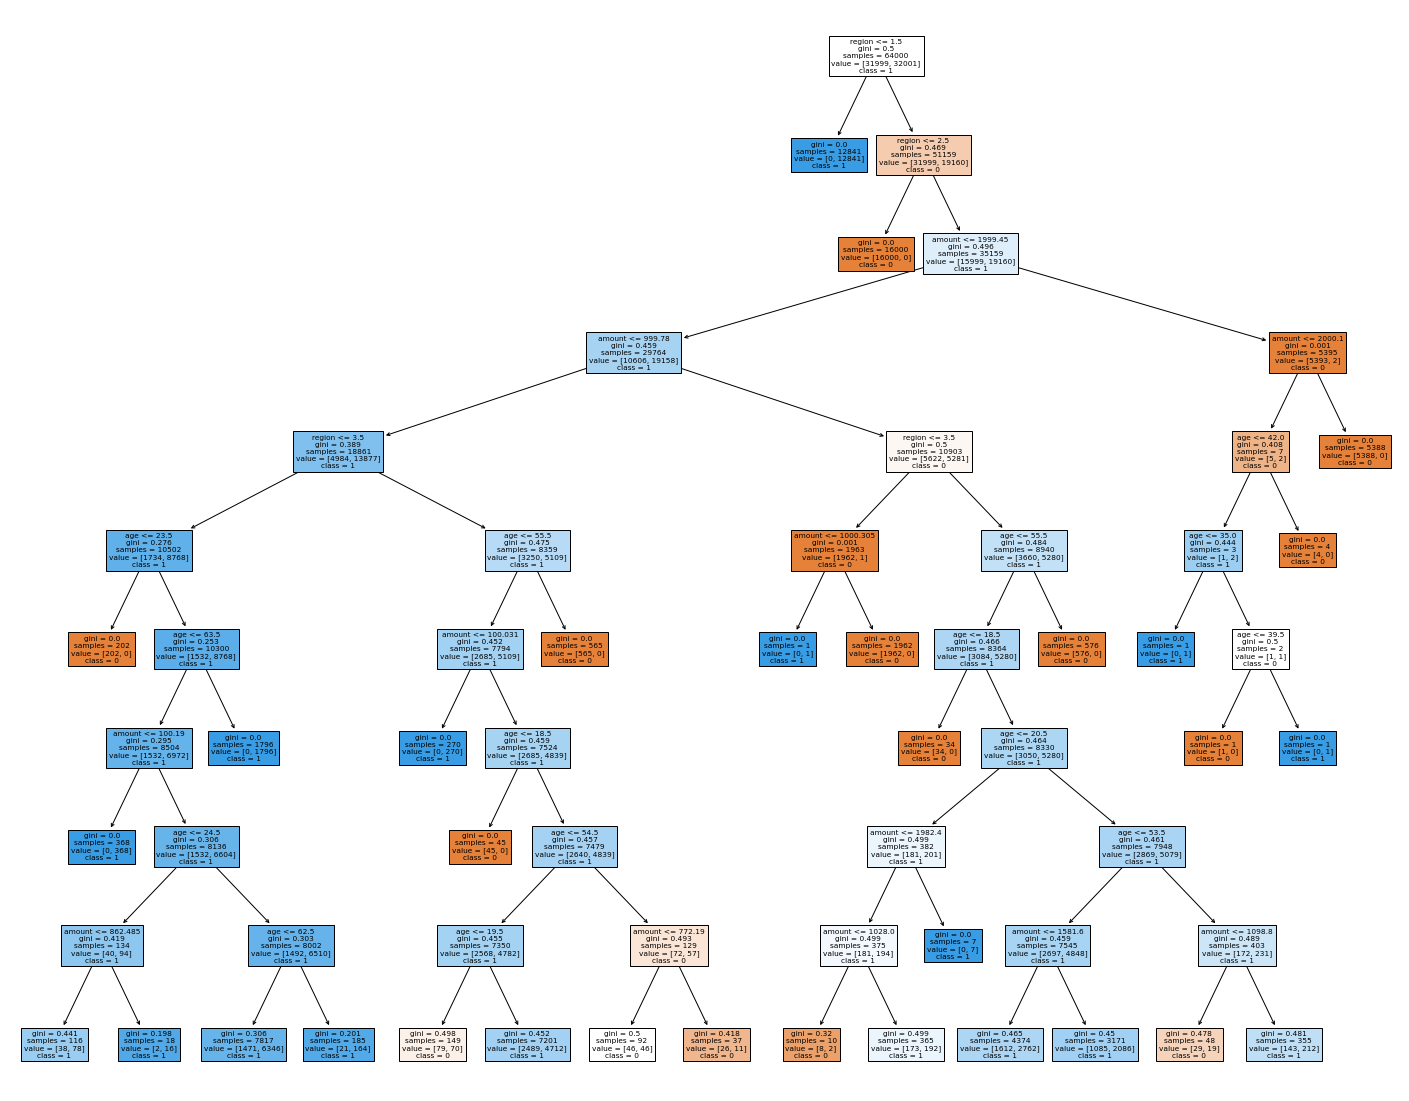

In [31]:
fig = plt.figure(figsize=(25,20))
tree = plot_tree(model, feature_names=X.columns,class_names=['0', '1', '2', '3'], filled=True)

## Conclusiones

El estudio ha posibilitado comprender mejor la relación entre las variables. Se ha observado que los clientes de la región 2 (sur) presentan edades mínima, máxima y mediana más elevadas que las otras regiones. Sin embargo, las cuatro regiones comparten una larga franja de edad (entre 28 y 63 años). Por eso, será difícil predecir la edad de un cliente considerando solo su región.

Tres modelos de clasificación han sido probados para intentar predecir la franja de edad de los clientes según otros dados disponibles, pero ninguno ha obtenido resultados satisfactorios. 

También se encontró una correlación entre la edad de un cliente y el tipo de compra es débil. A pesar de esto, se ha visualizado que los clientes que compran por internet tienen una edad média más alta que aquellos que compran en tiendas físicas. Además, el modelo de árbol de decisión ha sido bastante eficaz para predecir el tipo de compra, presentando un 89% de exactitud.